# Unet for farm boundary setection

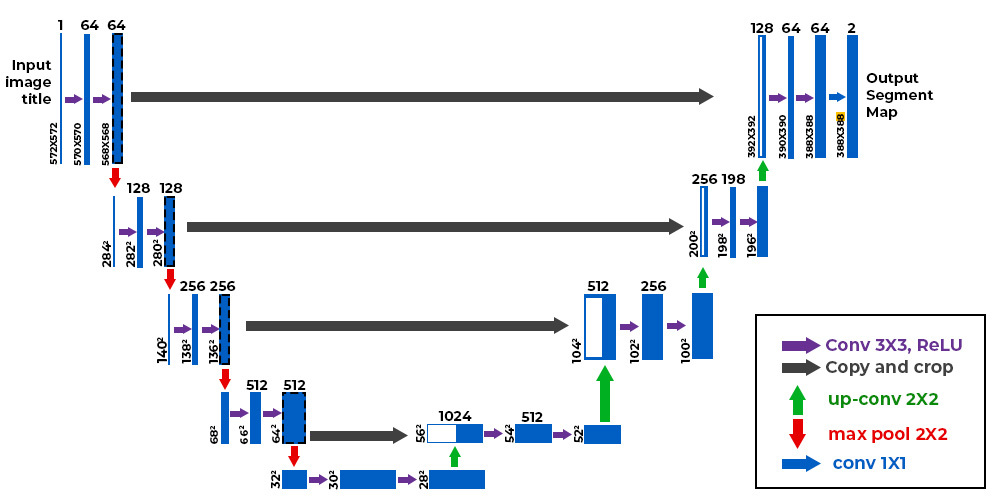

In [ ]:
import torch
import torch.nn as nn 
import os
from glob import glob 
from torch.utils.data import Dataset,DataLoader
from tqdm.notebook import tqdm 
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
import cv2
from unet_v2 import UNet
from torch.optim import SGD

## Datasets 

In [ ]:
## data loading and paired for img and mask images 



class farmdataset(Dataset):
    def __init__(self,paths):
        self.img = []
        self.annot = []
        
        for imgpath ,lblpath in (paths):
            img , label = self.__read_data(imgpath ,lblpath)
            if (label.sum() / (256**2)) > .4:
                self.img.append(img)
                self.annot.append(label)
            
    def __len__(self):
        return len(self.img)
            
    def __read_data(self, imagepath, labelpath):
        with rasterio.open(imagepath) as src:
            red = src.read(4)
            green = src.read(3)
            blue = src.read(2)
            nir = src.read(8)
        
            rgb_image = np.stack((blue, green, red, nir), axis=-1)
            imgdata = (rgb_image / rgb_image.max() * 255).astype(np.uint8)
 
        # imgdata = read_raster(imagepath)
        image = imgdata[:256, :256, :] / 255
        image = np.transpose(image, (2, 0, 1))

        label = cv2.imread(labelpath, -1)
        label = np.where(label == 255, 1,0)
        label= np.expand_dims(label,0)
        
        return image, label 

    def __getitem__(self, idx):
        image = self.img[idx]
        label = self.annot[idx]
        
        sample = {
            'data': torch.tensor(image, dtype=torch.float),
            'label': torch.tensor(label, dtype=torch.float)
        }
        
        return sample
    def plot(self,idx):
        image = self.img[idx]
        label = self.annot[idx]

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot data on the first subplot
        ax1.imshow(np.dstack(image[:3]))
        ax1.set_title('Image')
        
        # Plot data on the second subplot
        ax2.imshow(label[0])
        ax2.set_title('label')
        
        plt.tight_layout()
        
        # Display the plots
        plt.show()


image_paths =  '/home/surajit/d/PROJECTS/escortscubota_assigment/data/chunk/train_imgs/'
mask_paths = '/home/surajit/d/PROJECTS/escortscubota_assigment/data/chunk/mask_imgs/'

paired_images = []

files = glob(os.path.join(image_paths,'*.tif'))

for file in files:
    
    fname = os.path.basename(file)
    annoted_img  =fname.replace('img', 'mask') 
    
    img_path = os.path.join(image_paths,fname)
    annot_path =  os.path.join(mask_paths, annoted_img)
    
    if os.path.exists(img_path) and os.path.exists(annot_path):
        paired_images.append((img_path,annot_path))
 
    
image_label_paths_training , image_label_paths_validation = train_test_split(paired_images, train_size=0.7)


trainDS = farmdataset(image_label_paths_training)
testDS = farmdataset(image_label_paths_validation)
print('train :', len(trainDS), 'test :', len(testDS))

batch_size = 8
shuffle = True  # Whether to shuffle the data
num_workers = 4

train_dataloader = DataLoader(trainDS, batch_size=5, shuffle=shuffle, num_workers=num_workers)
validation_dataloader = DataLoader(testDS, batch_size=5, shuffle=shuffle, num_workers=num_workers)

# model building

In [ ]:
unet = UNet()
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)
lossFunc.to(device)

# Data Loader

In [ ]:
trainSteps = len(trainDS) // batch_size
testSteps = len(testDS) // batch_size
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}


for e in tqdm(range(150)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	for i, batch in enumerate(train_dataloader):
		# send the input to the device
		(x, y) = (batch['data'].to(device), batch['label'].to(device))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for i,batch in enumerate(validation_dataloader):
			# send the input to the device
			x, y = batch['data'].to(device), batch['label'].to(device)
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))


# Model saved

In [ ]:
model_scripted = torch.jit.script(unet) # Export to TorchScript
model_scripted.save('/home/surajit/d/PROJECTS/escortscubota_assigment/output/model/model_scripted.pt') # Save



# visualization

In [ ]:
for i,batch in enumerate(validation_dataloader):
    # send the input to the device
    x, y = batch['data'].to(device), batch['label'].to(device)
    # make the predictions and calculate the validation loss
    pred = unet(x)
    
    for y_pred , y_true in zip(pred.cpu().detach().numpy(), batch['label'].detach().numpy()):
        plt.subplot(1,2,1)
        plt.imshow(y_true[0])
        plt.subplot(1,2,2)
        plt.imshow(y_pred[0])
        plt.show()

In [ ]:
with open("/home/surajit/d/PROJECTS/escortscubota_assigment/data/chunk/test_imgs/test_images.txt", "w") as file:
    for item in image_label_paths_validation:
        file.write(f"{item}\n")
